In [376]:
import tweepy
import time
from config import bearer_token
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import nltk
import string

In [54]:

client = tweepy.Client(bearer_token, wait_on_rate_limit=True)

In [57]:
tweets = []
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = "to:NAkufoAddo lang:en -is:retweet",
                                 user_fields = ['public_metrics', 'description', 'location'],
                                 tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2011-02-20T00:00:00Z',
                                 end_time = '2022-09-30T00:00:00Z',
                                 max_results=500):
    time.sleep(1)
    tweets.append(response)

## Get Response Object

In [58]:
result = []
user_dict = {}
# Loop through each response object
for response in tweets:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = { 
                              'followers': user.public_metrics['followers_count'],
                              'tweets': user.public_metrics['tweet_count'],
                              'description': user.description,
                              'location': user.location
                             }
    for tweet in response.data:
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet.author_id, 
                       'author_followers': author_info['followers'],
                       'author_tweets': author_info['tweets'],
                       'author_description': author_info['description'],
                       'author_location': author_info['location'],
                       'text': tweet.text,
                       'created_at': tweet.created_at,
                       'retweets': tweet.public_metrics['retweet_count'],
                       'replies': tweet.public_metrics['reply_count'],
                       'likes': tweet.public_metrics['like_count'],
                       'quote_count': tweet.public_metrics['quote_count']
                      })

# Change this list of dictionaries into a dataframe
df = pd.DataFrame(result)

In [86]:
df['text'].head()

0     I'm a Kenyan how's this guy btw as president,...
1     So called patriots, still riding on a constit...
2     Welcome to Mali but we don't respect slaves h...
3     we are sorry. Whatever we do you we dey apolo...
4                                                 Wavy
Name: text, dtype: object

## Save Tweets Mined to CSV 

In [62]:
df.to_csv('tweets.csv')

In [63]:
# j = 1
# for tweet in tweets:
#     tweets = tweet.data
    
#     for i in range(len(tweets)):
#          print(j, tweets[i].created_at)                
#          print(" ")
#          j = j+ 1

In [287]:
tweets = pd.read_csv('tweets.csv')


In [288]:
tweets.shape

(311623, 12)

In [274]:
tweets.head()

,Unnamed: 0,author_id,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,0,1384094586608308225,1812,2404,"Football, science and carinformatic!",Ilovi,"@NAkufoAddo I'm a Kenyan how's this guy btw as president, Ghanaians?",2022-09-29 23:36:38+00:00,0,0,0,0
1,1,1464188219784937491,0,91,NaN,NaN,"@NAkufoAddo So called patriots, still riding on a constitution crafted under a man they called a dictator and flagrantly abusing the loopholes therein to their own merit and never having the will to craft a better one, in tandem to their own self acclaimed democratic stature; disgusting!!!",2022-09-29 22:21:10+00:00,0,0,0,0
2,2,119854589,3713,6388,"Économiste-statisticien, Analyste risque bancaire, CEO-Founder Fisher&Pearson \nDiplômé de Paris 1 Panthéon Sorbonne.\nBamako - Paris - London","London, England","@NAkufoAddo Welcome to #Mali but we don't respect slaves here. We remember very well who you are, a f** shame for #kwamenkrumah's Country. #Ghana",2022-09-29 21:56:09+00:00,0,0,0,0
3,3,328614729,1004,57661,same,Tema,@NAkufoAddo we are sorry. Whatever we do you we dey apologize Nana. Ei,2022-09-29 21:31:46+00:00,0,0,0,0
4,4,1265195729993314305,82,2274,"His Highness, Mandingue Descent, Mansa 👑. Presidential Candidate, Financier, Industrialist, Traveler, Historian. Africa & Diasporas. AFCFTA +Philanthropy🌍🇨🇮","Abidjan, Paris, New York",@NAkufoAddo Wavy,2022-09-29 20:56:17+00:00,0,0,0,0


In [289]:
tweets['text'][:10]

0                                                                                                                                                                                                                                  @NAkufoAddo I'm a Kenyan how's this guy btw as president, Ghanaians?
1    @NAkufoAddo So called patriots, still riding on a constitution crafted under a man they called a dictator and flagrantly abusing the loopholes therein to their own merit and never having the will to craft a better one, in tandem to their own self acclaimed democratic stature; disgusting!!!
2                                                                                                                                                     @NAkufoAddo Welcome to #Mali but we don't respect slaves here. We remember very well who you are, a f** shame for #kwamenkrumah's Country. #Ghana
3                                                                                                               

## Tweets Pre-Processing

### Tweets Cleaning

In [297]:
def clean_tweets1(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove @mentions
    text = re.sub(r'[0-9]', ' ', text) # remove numerics
    text = re.sub(r'@', '', text) # remove @ from tweets
    text = re.sub(r'\n', '', text) # remove \n from tweets
    text = re.sub(r'/', '', text) # remove \n from tweets
    text =re.sub(r'#', '', text) # remove the # symbol
    #text =re.sub(r'RT[\s', '', text) # remove RT
    text = re.sub(r'http\S+', '', text) # remove hyperlinks
    return text             


    

In [298]:
#apply method on the tweets to clean
tweets['text'] = tweets['text'].apply(clean_tweets1)

In [299]:
tweets['text'][:20]

0                                                                                                                                                                                                                                    I'm a Kenyan how's this guy btw as president, Ghanaians?
1      So called patriots, still riding on a constitution crafted under a man they called a dictator and flagrantly abusing the loopholes therein to their own merit and never having the will to craft a better one, in tandem to their own self acclaimed democratic stature; disgusting!!!
2                                                                                                                                                          Welcome to Mali but we don't respect slaves here. We remember very well who you are, a f** shame for kwamenkrumah's Country. Ghana
3                                                                                                                                             

In [300]:
pd.set_option('display.max_colwidth', None)
tweets['text'][55110:59119] # show portions of the clean text

55110                                                                                                                                                                         So they continue to impose more taxes. 😂😂😂. You don’t rate Ghanaians koraa o
55111                                                                                                                                                                                                                                           Wicked man
55112                     Good morning Mr President.Please, support me with a laptop to study. I'm an Information Technology (IT) student at Valley View, but I don't have laptop for my practicals and project works. Help me please, contact:           
55113                                                                                                                            Ene  gye s  almost all the youth get job Apuu how the system has become de  even if NPP win      I will leave the coun

### Working on Emojis and Emoticons

In [144]:
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS


In [145]:

# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text
# Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        return text

In [152]:
#df['text'] = df['text'].apply(convert_emoticons)

In [301]:
import emoji

In [362]:
def extract_emojis(text):
    return emoji.replace_emoji(text, replace='emoji.demojize(text)')


In [357]:
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')
    


#return ''.join((' '+c+' ') if c in emoji.demojize(s, language='en') else c for c in s)

In [353]:
emojis_removed = tweets

In [356]:
emojis_removed['text'][50:60]

50     A lot of pot hole on our roads but your aim is to complete your overheads I still don’t get you . Is it that the advisor are not doing there work or you don’t listen when they talk The youth are angry &amp; hungry Don’t let it get out of hand Think about the party &amp; Ghana
51      Teachers are suffering thru can’t complain, security sectors are facing the same, even the nurses are planning to move out the country due to the lack of support from you . The port is facing a huge problem no one has a solution to it . In fact all the sectors are crying act
52               If you don’t take care , the one who will represent the party next election will carry this your disgrace All sectors are not functioning anymore This your E- Cash system too is very boring For the past   days ECG is facing unbearable problems they can’t even handle
53                                                  is set to launch the National Energy Transmission Plan in November     . This will see the shift

In [380]:
emojis_removed['text'] = emojis_removed['text'].apply(remove_emojis)

In [381]:
emojis_removed['text'][50:60]

50     a lot of pot hole on our roads but your aim is to complete your overheads i still don’t get you  is it that the advisor are not doing there work or you don’t listen when they talk the youth are angry amp hungry don’t let it get out of hand think about the party amp ghana
51     teachers are suffering thru can’t complain security sectors are facing the same even the nurses are planning to move out the country due to the lack of support from you  the port is facing a huge problem no one has a solution to it  in fact all the sectors are crying act
52            if you don’t take care  the one who will represent the party next election will carry this your disgrace all sectors are not functioning anymore this your e cash system too is very boring for the past   days ecg is facing unbearable problems they can’t even handle
53                                                is set to launch the national energy transmission plan in november      this will see the shift from fossil fuels

In [366]:
emojis_removed.shape

(311623, 12)

### Further Cleaning

In [384]:
def clean_tweets2(text): 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text.lower()

In [385]:
new_clean_tweet = emojis_removed
new_clean_tweet['text'] = new_clean_tweet['text'].apply(clean_tweets2)

In [ ]:
new_clean_tweet['text'][300000:3000025]

### Correct Wrong Spellings

In [392]:

from textblob import TextBlob
 

In [389]:
def correct_spellings(text):
    text  = TextBlob(text)
    return text.correct()

In [394]:
#new_clean_tweet['text'] = new_clean_tweet['text'].apply(correct_spellings)

In [397]:
new_clean_tweet['text'].shape

(311623,)

## Computing Polarity and Subjectivity

In [398]:
# get polarity
def getPolarityy(text):
    return TextBlob(text).sentiment.polarity



In [404]:
# get subjectivity 
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity



In [400]:
# create two new columns
new_clean_tweet['Polarity'] = new_clean_tweet['text'].apply(getPolarityy)

In [405]:
new_clean_tweet['Subjectivity'] = new_clean_tweet['text'].apply(getSubjectivity)

In [403]:
new_clean_tweet['Polarity'][1010:1020]

1010    0.10
1011    0.50
1012    1.00
1013    0.80
1014    0.60
1015    0.35
1016    0.00
1017    0.00
1018   -0.20
1019    0.00
Name: Polarity, dtype: float64

In [406]:
new_clean_tweet['Subjectivity'].head()

0    0.000
1    0.875
2    0.600
3    1.000
4    0.000
Name: Subjectivity, dtype: float64

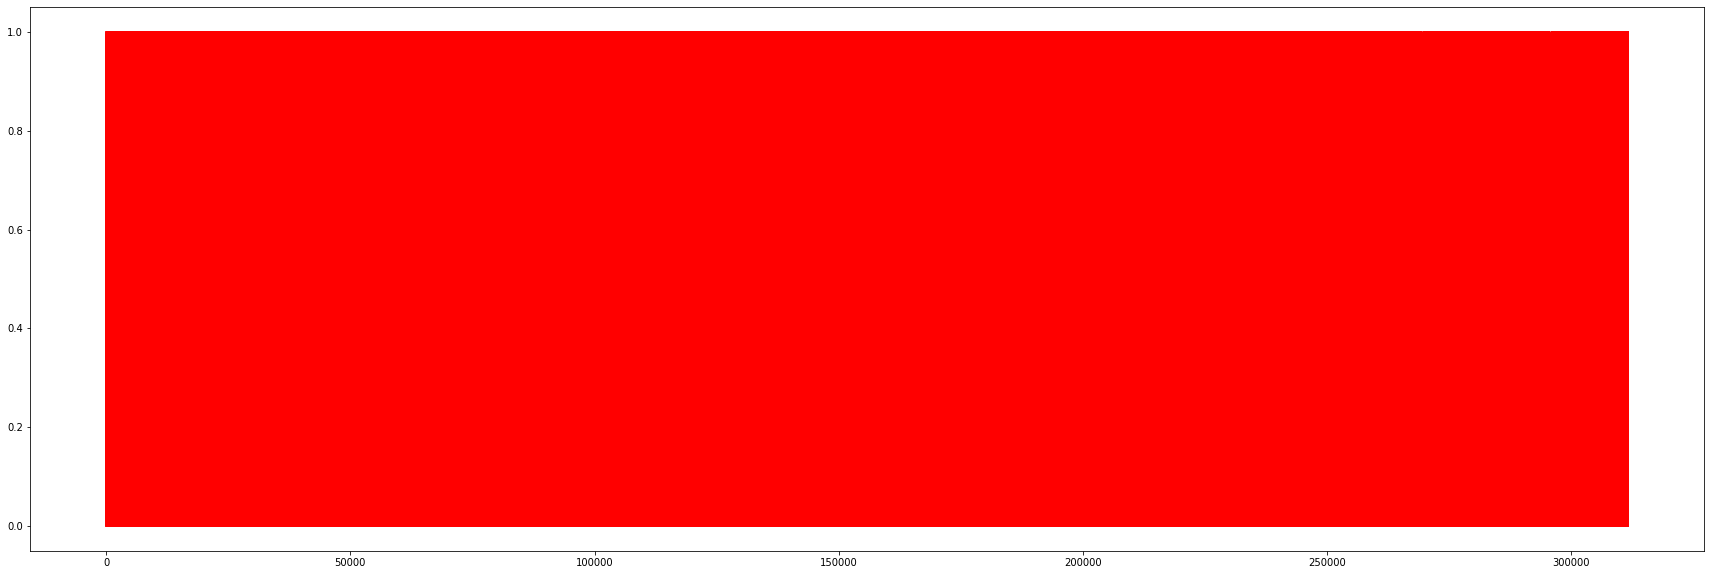

In [411]:
import matplotlib.pyplot as plt
new_clean_tweet['Subjectivity'].plot(
                kind='line',
                figsize=(30,10),
                color = 'red'
)
plt.show()

In [ ]:
import pandas as pd
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])
df = df.sort_index()


In [415]:
new_clean_tweet[['created_at', 'text']].tail(5)

,created_at,text
311618,2011-02-22 09:42:15+00:00,yes you are doing a good job for our dear nation ghana god richer y bless youamen
311619,2011-02-21 23:08:02+00:00,i support b i gyes the believe in ghana agenda and the npp not failedghanaagenda
311620,2011-02-21 17:52:37+00:00,niggaa u are too desperate power
311621,2011-02-21 13:56:44+00:00,good speech from a real leader not mills keep it up failedghanaagenda
311622,2011-02-21 13:48:43+00:00,good speech from a real leader keep this up


In [418]:
new_clean_tweet['created-at'] = pd.to_datetime(new_clean_tweet['created_at'])
new_clean_tweet = new_clean_tweet.set_index(new_clean_tweet['created_at'])
new_clean_tweet = new_clean_tweet.sort_index()

In [419]:
before_election = new_clean_tweet['2011-02-21':'2011-12-31']

In [421]:
before_election.shape

(180, 15)

In [437]:
before_election[['created_at', 'text']].tail(5)

,created_at,text
created_at,,
2011-12-25 16:36:54+00:00,2011-12-25 16:36:54+00:00,many many happy returns
2011-12-25 16:45:32+00:00,2011-12-25 16:45:32+00:00,for president gh my gift for next years christmas zw y df
2011-12-25 17:38:02+00:00,2011-12-25 17:38:02+00:00,merry christmas and a prosperous new year i love ur family picturelovely
2011-12-28 07:44:36+00:00,2011-12-28 07:44:36+00:00,victory shall be ours insha allah
2011-12-30 10:17:24+00:00,2011-12-30 10:17:24+00:00,many still prefer dr bawumia kwasi the taxi driver tells me


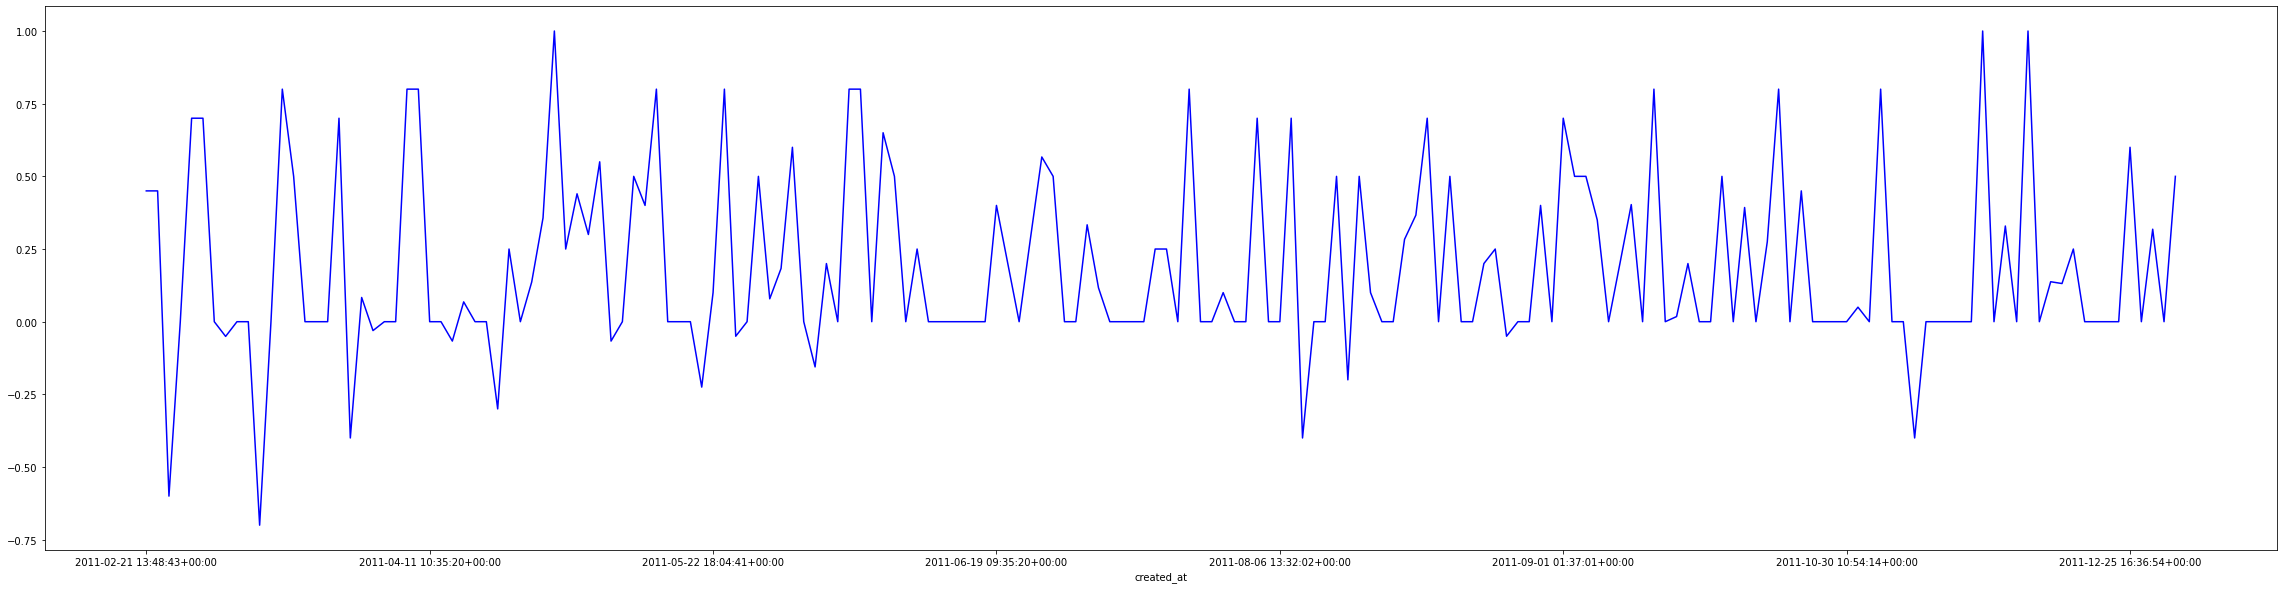

In [443]:
initial_polarity = before_election['Polarity'].plot(
                kind='line',
                figsize=(40,10),
                color = 'blue'
)
plt.show()

In [444]:
initial_polarity.figure.savefig('initial_polarity.png')

In [434]:
current_year = new_clean_tweet['2022-01-01':'2022-01-10']

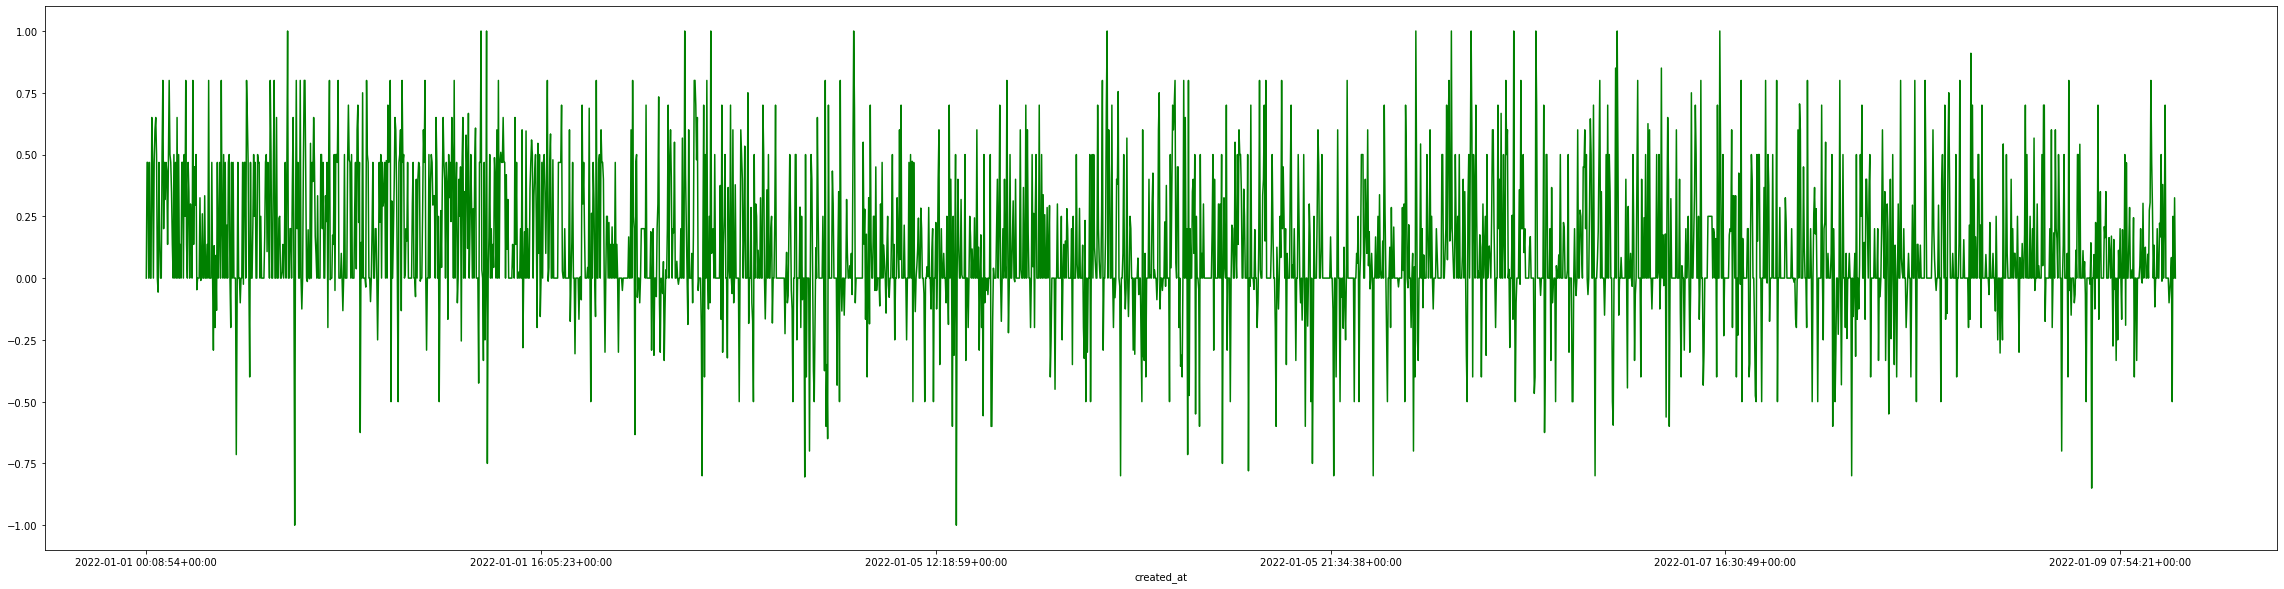

In [438]:
 current = current_year['Polarity'].plot(
                kind='line',
                figsize=(40,10),
                color = 'green'
)
plt.show()

In [439]:
current

<AxesSubplot:xlabel='created_at'>

In [445]:
current.figure.savefig('current_polarity.png')